In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras import regularizers

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/미래에셋/final_naver.csv')

data.index = data["Date"]
data.drop("Date", axis = 1, inplace = True)
data

,Open,High,Low,Close,Volume,Change,5MA,5Disparity,20MA,20Disparity,60MA,60Disparity,120MA,120Disparity,label
Date,,,,,,,,,,,,,,,
2021-06-01,362500,368500,362500,367000,404110,0.012414,361700.0,1.014653,355525.0,1.032276,373000.000000,0.983914,351354.166667,1.044530,0.000000
2021-06-02,367000,369000,362000,363000,397044,-0.010899,361700.0,1.003594,355525.0,1.021025,372908.333333,0.973430,351929.166667,1.031458,0.000000
2021-06-03,362500,365000,361000,362000,292257,-0.002755,362500.0,0.998621,355400.0,1.018571,372916.666667,0.970726,352533.333333,1.026853,-1.000000
2021-06-04,360500,360500,355000,357000,433146,-0.013812,362300.0,0.985371,355175.0,1.005138,372666.666667,0.957961,353133.333333,1.010950,1.000000
2021-06-07,358500,364000,357000,362500,393697,0.015406,362300.0,1.000552,355250.0,1.020408,372483.333333,0.973198,353754.166667,1.024723,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,180000,180100,177400,179000,558709,0.000000,181180.0,0.987968,185685.0,0.963998,187181.666667,0.956290,200940.000000,0.890813,0.000000
2024-05-28,178500,178700,177400,177400,563865,-0.008939,180020.0,0.985446,185420.0,0.956747,186805.000000,0.949653,200689.166667,0.883954,0.142857
2024-05-29,178100,179800,175100,175300,898094,-0.011838,178560.0,0.981743,185110.0,0.947004,186326.666667,0.940821,200420.833333,0.874660,0.208955


[[ 3.62500000e+05  3.68500000e+05  3.62500000e+05  3.67000000e+05
   4.04110000e+05  1.24137931e-02  3.61700000e+05  1.01465303e+00
   3.55525000e+05  1.03227621e+00  3.73000000e+05  9.83914209e-01
   3.51354167e+05  1.04453009e+00  0.00000000e+00]
 [ 3.67000000e+05  3.69000000e+05  3.62000000e+05  3.63000000e+05
   3.97044000e+05 -1.08991826e-02  3.61700000e+05  1.00359414e+00
   3.55525000e+05  1.02102524e+00  3.72908333e+05  9.73429574e-01
   3.51929167e+05  1.03145756e+00  0.00000000e+00]
 [ 3.62500000e+05  3.65000000e+05  3.61000000e+05  3.62000000e+05
   2.92257000e+05 -2.75482094e-03  3.62500000e+05  9.98620690e-01
   3.55400000e+05  1.01857062e+00  3.72916667e+05  9.70726257e-01
   3.52533333e+05  1.02685325e+00 -1.00000000e+00]
 [ 3.60500000e+05  3.60500000e+05  3.55000000e+05  3.57000000e+05
   4.33146000e+05 -1.38121547e-02  3.62300000e+05  9.85371239e-01
   3.55175000e+05  1.00513831e+00  3.72666667e+05  9.57960644e-01
   3.53133333e+05  1.01094959e+00  1.00000000e+00]
 [ 3

<Figure size 1400x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted')

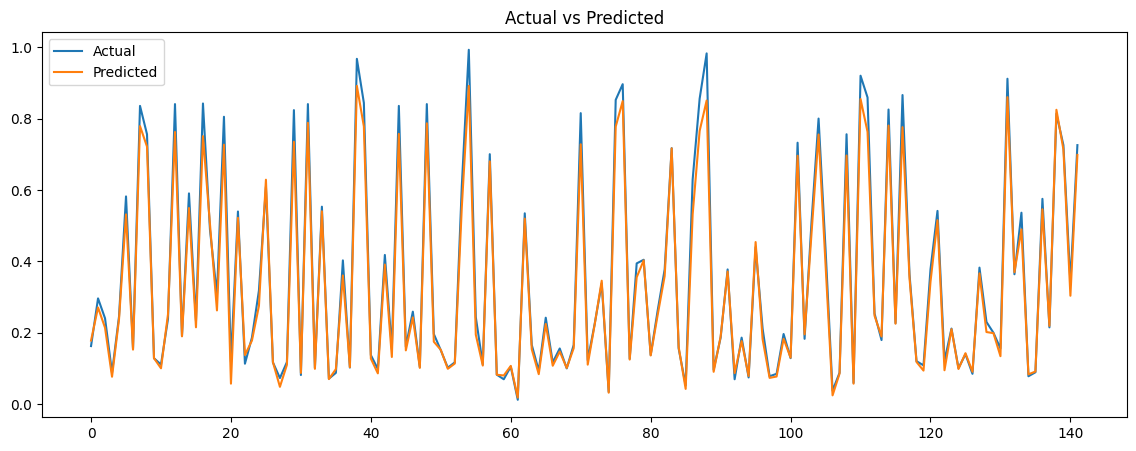

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training and Validation Loss')

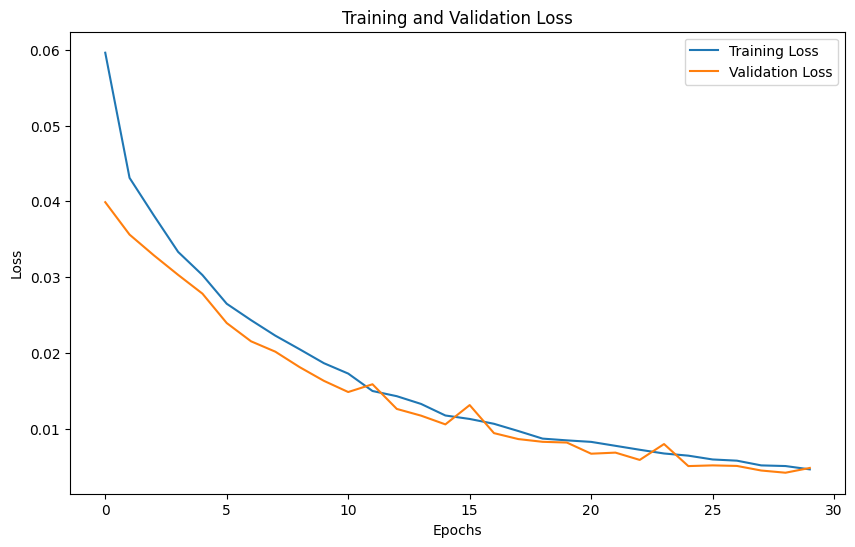

In [ ]:
### 에포크 30

from tensorflow.keras.layers import GRU, Dense, Dropout
TARGET = "Close"
SEQ_SIZE = 30
PRED_SIZE = 1
EPOCH = 30
BATCH_SIZE = 16

def split_xy(dataset, time_steps, y_column):
    x, y = [], []
    for i in range(len(dataset) - time_steps - y_column):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column
        x.append(dataset.iloc[i:x_end_number, :].values)
        y.append(dataset.iloc[x_end_number:y_end_number, :][TARGET].values)
    return np.array(x), np.array(y)

X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
print(X[0], "\n", y[0])
print("X size:", X.shape)
print("y size:", y.shape)

# 시퀀스별로 Min-Max 정규화
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler.fit_transform(y)

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 초기화 함수 정의
initializer = GlorotNormal()

# 모델 구성
model = Sequential()
model.add(GRU(128, input_shape=(SEQ_SIZE, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model.predict(X_test)

# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

[[ 3.62500000e+05  3.68500000e+05  3.62500000e+05  3.67000000e+05
   4.04110000e+05  1.24137931e-02  3.61700000e+05  1.01465303e+00
   3.55525000e+05  1.03227621e+00  3.73000000e+05  9.83914209e-01
   3.51354167e+05  1.04453009e+00  0.00000000e+00]
 [ 3.67000000e+05  3.69000000e+05  3.62000000e+05  3.63000000e+05
   3.97044000e+05 -1.08991826e-02  3.61700000e+05  1.00359414e+00
   3.55525000e+05  1.02102524e+00  3.72908333e+05  9.73429574e-01
   3.51929167e+05  1.03145756e+00  0.00000000e+00]
 [ 3.62500000e+05  3.65000000e+05  3.61000000e+05  3.62000000e+05
   2.92257000e+05 -2.75482094e-03  3.62500000e+05  9.98620690e-01
   3.55400000e+05  1.01857062e+00  3.72916667e+05  9.70726257e-01
   3.52533333e+05  1.02685325e+00 -1.00000000e+00]
 [ 3.60500000e+05  3.60500000e+05  3.55000000e+05  3.57000000e+05
   4.33146000e+05 -1.38121547e-02  3.62300000e+05  9.85371239e-01
   3.55175000e+05  1.00513831e+00  3.72666667e+05  9.57960644e-01
   3.53133333e+05  1.01094959e+00  1.00000000e+00]
 [ 3

<Figure size 1400x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted')

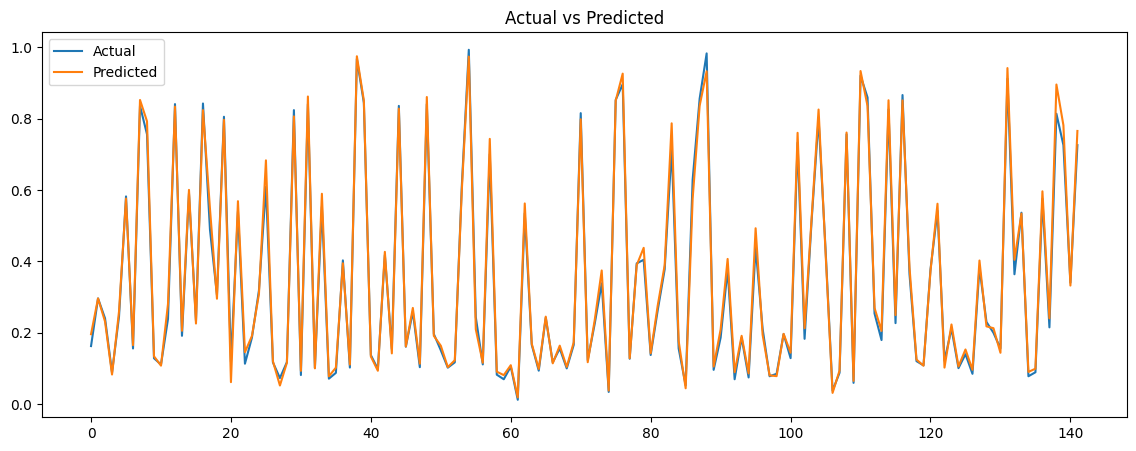

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training and Validation Loss')

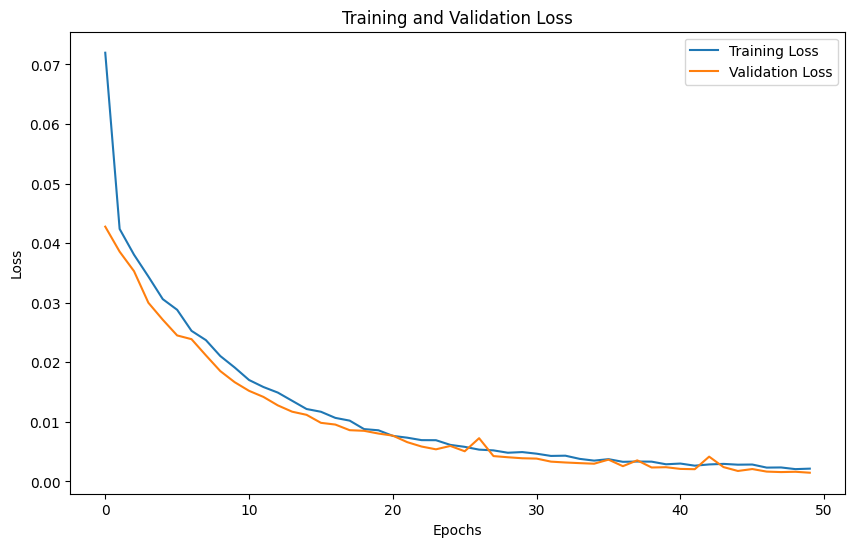

In [ ]:
### 에포크 50

from tensorflow.keras.layers import GRU, Dense, Dropout
TARGET = "Close"
SEQ_SIZE = 30
PRED_SIZE = 1
EPOCH = 50
BATCH_SIZE = 16

def split_xy(dataset, time_steps, y_column):
    x, y = [], []
    for i in range(len(dataset) - time_steps - y_column):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column
        x.append(dataset.iloc[i:x_end_number, :].values)
        y.append(dataset.iloc[x_end_number:y_end_number, :][TARGET].values)
    return np.array(x), np.array(y)

X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
print(X[0], "\n", y[0])
print("X size:", X.shape)
print("y size:", y.shape)

# 시퀀스별로 Min-Max 정규화
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler.fit_transform(y)

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 초기화 함수 정의
initializer = GlorotNormal()

# 모델 구성
model = Sequential()
model.add(GRU(128, input_shape=(SEQ_SIZE, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model.predict(X_test)

# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

[[ 3.62500000e+05  3.68500000e+05  3.62500000e+05  3.67000000e+05
   4.04110000e+05  1.24137931e-02  3.61700000e+05  1.01465303e+00
   3.55525000e+05  1.03227621e+00  3.73000000e+05  9.83914209e-01
   3.51354167e+05  1.04453009e+00  0.00000000e+00]
 [ 3.67000000e+05  3.69000000e+05  3.62000000e+05  3.63000000e+05
   3.97044000e+05 -1.08991826e-02  3.61700000e+05  1.00359414e+00
   3.55525000e+05  1.02102524e+00  3.72908333e+05  9.73429574e-01
   3.51929167e+05  1.03145756e+00  0.00000000e+00]
 [ 3.62500000e+05  3.65000000e+05  3.61000000e+05  3.62000000e+05
   2.92257000e+05 -2.75482094e-03  3.62500000e+05  9.98620690e-01
   3.55400000e+05  1.01857062e+00  3.72916667e+05  9.70726257e-01
   3.52533333e+05  1.02685325e+00 -1.00000000e+00]
 [ 3.60500000e+05  3.60500000e+05  3.55000000e+05  3.57000000e+05
   4.33146000e+05 -1.38121547e-02  3.62300000e+05  9.85371239e-01
   3.55175000e+05  1.00513831e+00  3.72666667e+05  9.57960644e-01
   3.53133333e+05  1.01094959e+00  1.00000000e+00]
 [ 3

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


57/57 [==============================] - 5s 13ms/step - loss: 69476302848.0000 - val_loss: 76246122496.0000
Epoch 2/50
57/57 [==============================] - 0s 6ms/step - loss: 69476057088.0000 - val_loss: 76245737472.0000
Epoch 3/50
57/57 [==============================] - 0s 6ms/step - loss: 69475442688.0000 - val_loss: 76244738048.0000
Epoch 4/50
57/57 [==============================] - 0s 6ms/step - loss: 69473845248.0000 - val_loss: 76242214912.0000
Epoch 5/50
57/57 [==============================] - 0s 7ms/step - loss: 69470707712.0000 - val_loss: 76238249984.0000
Epoch 6/50
57/57 [==============================] - 0s 6ms/step - loss: 69466374144.0000 - val_loss: 76233105408.0000
Epoch 7/50
57/57 [==============================] - 0s 6ms/step - loss: 69460844544.0000 - val_loss: 76226617344.0000
Epoch 8/50
57/57 [==============================] - 0s 8ms/step - loss: 69453791232.0000 - val_loss: 76218277888.0000
Epoch 9/50
57/57 [==============================] - 0s 8ms/step - 

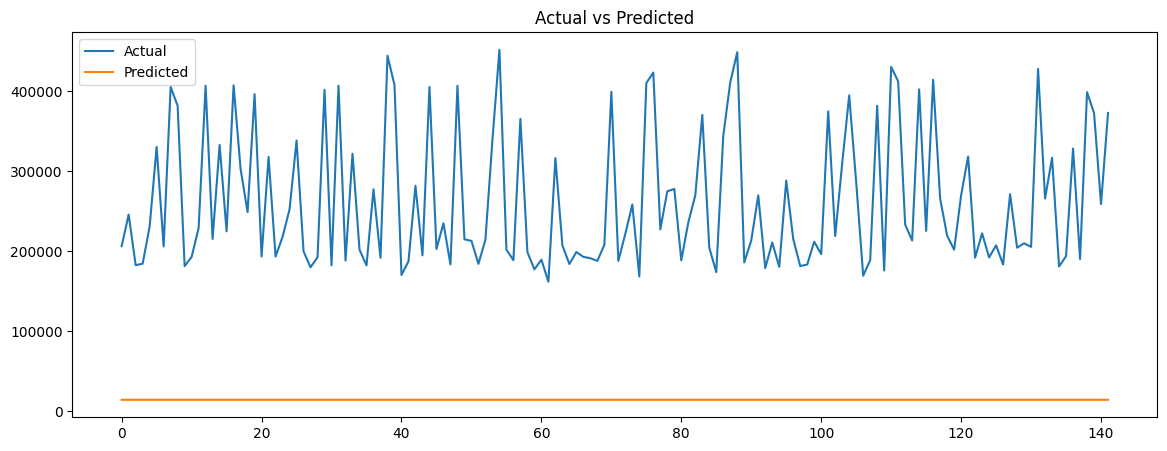

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras import regularizers

# 데이터 로드
data = pd.read_csv('/content/drive/MyDrive/미래에셋/final_naver.csv')
data.index = data["Date"]
data.drop("Date", axis = 1, inplace = True)
data

TARGET = "Close"
SEQ_SIZE = 30    # 10/30/60
PRED_SIZE = 1
LEARNING_RATE = 0.0001
EPOCH = 50
BATCH_SIZE = 8

def split_xy(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        tmp_x = dataset.iloc[i:x_end_number, :]
        tmp_y = dataset.iloc[x_end_number:y_end_number, :].loc[:, TARGET]
        x.append(tmp_x.values)
        y.append(tmp_y.values)

    return np.array(x), np.array(y)

X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
print(X[0],"\n", y[0])
print("X size : ", X.shape)
print("y size : ", y.shape)

# 시퀀스별로 Min-Max 정규화
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        min_val = np.min(X[i, :, j])
        max_val = np.max(X[i, :, j])
        if min_val == max_val:
            X[i, :, j] = 0
        else:
            X[i, :, j] = (X[i, :, j] - min_val) / (max_val - min_val)

# 결과 확인
print(X.shape)

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 초기화 함수
initializer = GlorotNormal()

# 모델 구성
model = Sequential([
    GRU(32, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.003)),
    Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.003)),
    Dense(16, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.003)),
    Dense(1)  # 회귀 문제이므로 출력층에 활성화 함수 사용 안 함
])
optimizer = Adam(learning_rate=LEARNING_RATE)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model.predict(X_test)

# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()


In [4]:
# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 68600484057.64645
RMSE: 261916.94114288685
MAE: 247589.1922865317


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


57/57 [==============================] - 5s 21ms/step - loss: 69470740480.0000 - val_loss: 76226338816.0000
Epoch 2/100
57/57 [==============================] - 1s 10ms/step - loss: 69399404544.0000 - val_loss: 76046041088.0000
Epoch 3/100
57/57 [==============================] - 1s 10ms/step - loss: 68963336192.0000 - val_loss: 75172216832.0000
Epoch 4/100
57/57 [==============================] - 1s 12ms/step - loss: 67376185344.0000 - val_loss: 72477859840.0000
Epoch 5/100
57/57 [==============================] - 1s 13ms/step - loss: 63388676096.0000 - val_loss: 66480820224.0000
Epoch 6/100
57/57 [==============================] - 1s 13ms/step - loss: 55628484608.0000 - val_loss: 55934926848.0000
Epoch 7/100
57/57 [==============================] - 1s 9ms/step - loss: 43564580864.0000 - val_loss: 41222205440.0000
Epoch 8/100
57/57 [==============================] - 0s 8ms/step - loss: 29005309952.0000 - val_loss: 25662582784.0000
Epoch 9/100
57/57 [==============================] - 0

<Figure size 1400x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted')

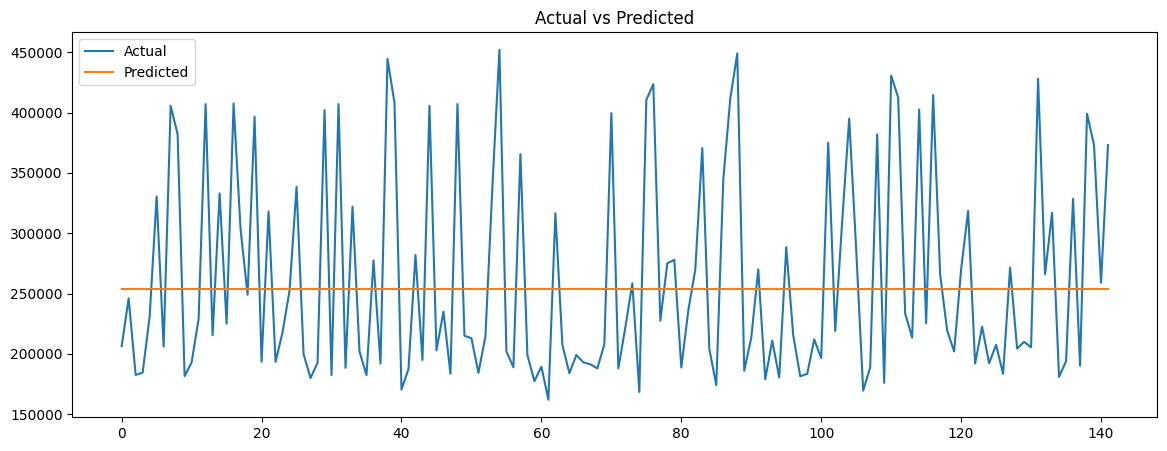

In [5]:
# 모델 구성
model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    GRU(32),
    Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)),
    Dense(16, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)),
    Dense(1)
])
optimizer = Adam(learning_rate=LEARNING_RATE * 10)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCH * 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model.predict(X_test)

# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()


,Open,High,Low,Close,Volume,Change,5MA,5Disparity,20MA,20Disparity,60MA,60Disparity,120MA,120Disparity,label
Date,,,,,,,,,,,,,,,
2021-06-01,362500,368500,362500,367000,404110,0.012414,361700.0,1.014653,355525.0,1.032276,373000.000000,0.983914,351354.166667,1.044530,0.000000
2021-06-02,367000,369000,362000,363000,397044,-0.010899,361700.0,1.003594,355525.0,1.021025,372908.333333,0.973430,351929.166667,1.031458,0.000000
2021-06-03,362500,365000,361000,362000,292257,-0.002755,362500.0,0.998621,355400.0,1.018571,372916.666667,0.970726,352533.333333,1.026853,-1.000000
2021-06-04,360500,360500,355000,357000,433146,-0.013812,362300.0,0.985371,355175.0,1.005138,372666.666667,0.957961,353133.333333,1.010950,1.000000
2021-06-07,358500,364000,357000,362500,393697,0.015406,362300.0,1.000552,355250.0,1.020408,372483.333333,0.973198,353754.166667,1.024723,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,180000,180100,177400,179000,558709,0.000000,181180.0,0.987968,185685.0,0.963998,187181.666667,0.956290,200940.000000,0.890813,0.000000
2024-05-28,178500,178700,177400,177400,563865,-0.008939,180020.0,0.985446,185420.0,0.956747,186805.000000,0.949653,200689.166667,0.883954,0.142857
2024-05-29,178100,179800,175100,175300,898094,-0.011838,178560.0,0.981743,185110.0,0.947004,186326.666667,0.940821,200420.833333,0.874660,0.208955


[[ 3.62500000e+05  3.68500000e+05  3.62500000e+05  3.67000000e+05
   4.04110000e+05  1.24137931e-02  3.61700000e+05  1.01465303e+00
   3.55525000e+05  1.03227621e+00  3.73000000e+05  9.83914209e-01
   3.51354167e+05  1.04453009e+00  0.00000000e+00]
 [ 3.67000000e+05  3.69000000e+05  3.62000000e+05  3.63000000e+05
   3.97044000e+05 -1.08991826e-02  3.61700000e+05  1.00359414e+00
   3.55525000e+05  1.02102524e+00  3.72908333e+05  9.73429574e-01
   3.51929167e+05  1.03145756e+00  0.00000000e+00]
 [ 3.62500000e+05  3.65000000e+05  3.61000000e+05  3.62000000e+05
   2.92257000e+05 -2.75482094e-03  3.62500000e+05  9.98620690e-01
   3.55400000e+05  1.01857062e+00  3.72916667e+05  9.70726257e-01
   3.52533333e+05  1.02685325e+00 -1.00000000e+00]
 [ 3.60500000e+05  3.60500000e+05  3.55000000e+05  3.57000000e+05
   4.33146000e+05 -1.38121547e-02  3.62300000e+05  9.85371239e-01
   3.55175000e+05  1.00513831e+00  3.72666667e+05  9.57960644e-01
   3.53133333e+05  1.01094959e+00  1.00000000e+00]
 [ 3

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


57/57 [==============================] - 6s 19ms/step - loss: 69464555520.0000 - val_loss: 76203900928.0000
Epoch 2/100
57/57 [==============================] - 0s 8ms/step - loss: 69325504512.0000 - val_loss: 75872722944.0000
Epoch 3/100
57/57 [==============================] - 0s 8ms/step - loss: 68613316608.0000 - val_loss: 74525335552.0000
Epoch 4/100
57/57 [==============================] - 0s 8ms/step - loss: 66360066048.0000 - val_loss: 70840606720.0000
Epoch 5/100
57/57 [==============================] - 0s 8ms/step - loss: 61136474112.0000 - val_loss: 63252451328.0000
Epoch 6/100
57/57 [==============================] - 0s 9ms/step - loss: 51738865664.0000 - val_loss: 50944237568.0000
Epoch 7/100
57/57 [==============================] - 0s 8ms/step - loss: 38361264128.0000 - val_loss: 35428151296.0000
Epoch 8/100
57/57 [==============================] - 0s 8ms/step - loss: 23751000064.0000 - val_loss: 20624160768.0000
Epoch 9/100
57/57 [==============================] - 0s 8ms

<Figure size 1400x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted')

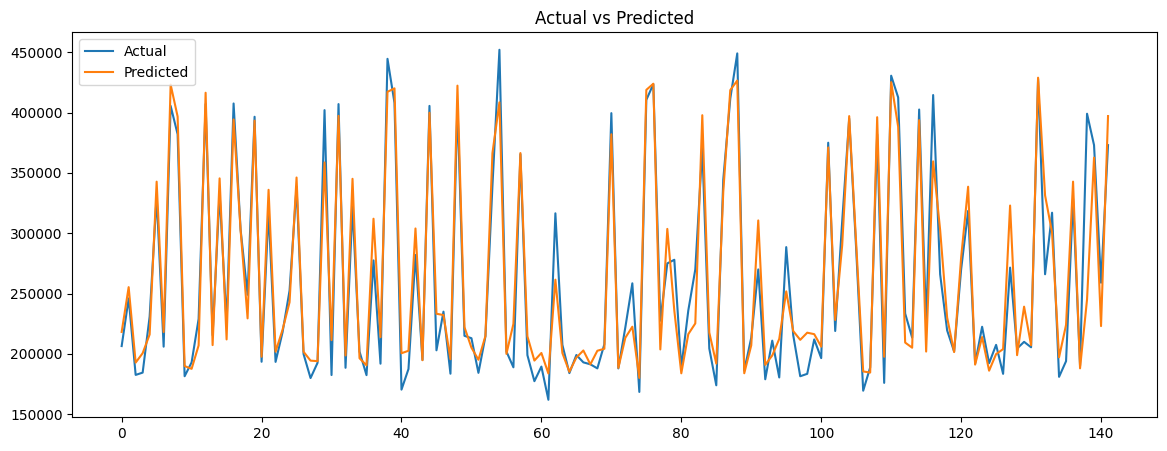

In [6]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras import regularizers

# 데이터 로드
data = pd.read_csv('/content/drive/MyDrive/미래에셋/final_naver.csv')
data.index = data["Date"]
data.drop("Date", axis = 1, inplace = True)
data

TARGET = "Close"
SEQ_SIZE = 30    # 10/30/60
PRED_SIZE = 1
LEARNING_RATE = 0.0001
EPOCH = 50
BATCH_SIZE = 8

def split_xy(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        tmp_x = dataset.iloc[i:x_end_number, :]
        tmp_y = dataset.iloc[x_end_number:y_end_number, :].loc[:, TARGET]
        x.append(tmp_x.values)
        y.append(tmp_y.values)

    return np.array(x), np.array(y)

X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
print(X[0],"\n", y[0])
print("X size : ", X.shape)
print("y size : ", y.shape)

# 시퀀스별로 Min-Max 정규화
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        min_val = np.min(X[i, :, j])
        max_val = np.max(X[i, :, j])
        if min_val == max_val:
            X[i, :, j] = 0
        else:
            X[i, :, j] = (X[i, :, j] - min_val) / (max_val - min_val)

# 결과 확인
print(X.shape)

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 초기화 함수
initializer = GlorotNormal()

# 모델 구성
model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    GRU(32),
    Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)),
    Dense(16, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)),
    Dense(1)
])
optimizer = Adam(learning_rate=LEARNING_RATE * 10)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCH * 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model.predict(X_test)

# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()



,Open,High,Low,Close,Volume,Change,5MA,5Disparity,20MA,20Disparity,60MA,60Disparity,120MA,120Disparity,label
Date,,,,,,,,,,,,,,,
2021-06-01,362500,368500,362500,367000,404110,0.012414,361700.0,1.014653,355525.0,1.032276,373000.000000,0.983914,351354.166667,1.044530,0.000000
2021-06-02,367000,369000,362000,363000,397044,-0.010899,361700.0,1.003594,355525.0,1.021025,372908.333333,0.973430,351929.166667,1.031458,0.000000
2021-06-03,362500,365000,361000,362000,292257,-0.002755,362500.0,0.998621,355400.0,1.018571,372916.666667,0.970726,352533.333333,1.026853,-1.000000
2021-06-04,360500,360500,355000,357000,433146,-0.013812,362300.0,0.985371,355175.0,1.005138,372666.666667,0.957961,353133.333333,1.010950,1.000000
2021-06-07,358500,364000,357000,362500,393697,0.015406,362300.0,1.000552,355250.0,1.020408,372483.333333,0.973198,353754.166667,1.024723,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,180000,180100,177400,179000,558709,0.000000,181180.0,0.987968,185685.0,0.963998,187181.666667,0.956290,200940.000000,0.890813,0.000000
2024-05-28,178500,178700,177400,177400,563865,-0.008939,180020.0,0.985446,185420.0,0.956747,186805.000000,0.949653,200689.166667,0.883954,0.142857
2024-05-29,178100,179800,175100,175300,898094,-0.011838,178560.0,0.981743,185110.0,0.947004,186326.666667,0.940821,200420.833333,0.874660,0.208955


[[ 3.62500000e+05  3.68500000e+05  3.62500000e+05  3.67000000e+05
   4.04110000e+05  1.24137931e-02  3.61700000e+05  1.01465303e+00
   3.55525000e+05  1.03227621e+00  3.73000000e+05  9.83914209e-01
   3.51354167e+05  1.04453009e+00  0.00000000e+00]
 [ 3.67000000e+05  3.69000000e+05  3.62000000e+05  3.63000000e+05
   3.97044000e+05 -1.08991826e-02  3.61700000e+05  1.00359414e+00
   3.55525000e+05  1.02102524e+00  3.72908333e+05  9.73429574e-01
   3.51929167e+05  1.03145756e+00  0.00000000e+00]
 [ 3.62500000e+05  3.65000000e+05  3.61000000e+05  3.62000000e+05
   2.92257000e+05 -2.75482094e-03  3.62500000e+05  9.98620690e-01
   3.55400000e+05  1.01857062e+00  3.72916667e+05  9.70726257e-01
   3.52533333e+05  1.02685325e+00 -1.00000000e+00]
 [ 3.60500000e+05  3.60500000e+05  3.55000000e+05  3.57000000e+05
   4.33146000e+05 -1.38121547e-02  3.62300000e+05  9.85371239e-01
   3.55175000e+05  1.00513831e+00  3.72666667e+05  9.57960644e-01
   3.53133333e+05  1.01094959e+00  1.00000000e+00]
 [ 3

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


29/29 [==============================] - 5s 31ms/step - loss: 69469233152.0000 - val_loss: 76220170240.0000
Epoch 2/30
29/29 [==============================] - 0s 10ms/step - loss: 69390573568.0000 - val_loss: 76030124032.0000
Epoch 3/30
29/29 [==============================] - 0s 10ms/step - loss: 68989239296.0000 - val_loss: 75242971136.0000
Epoch 4/30
29/29 [==============================] - 0s 8ms/step - loss: 67673501696.0000 - val_loss: 73019842560.0000
Epoch 5/30
29/29 [==============================] - 0s 8ms/step - loss: 64450027520.0000 - val_loss: 68119576576.0000
Epoch 6/30
29/29 [==============================] - 0s 10ms/step - loss: 58048987136.0000 - val_loss: 59315916800.0000
Epoch 7/30
29/29 [==============================] - 0s 11ms/step - loss: 47656067072.0000 - val_loss: 46223261696.0000
Epoch 8/30
29/29 [==============================] - 0s 8ms/step - loss: 33858842624.0000 - val_loss: 30455042048.0000
Epoch 9/30
29/29 [==============================] - 0s 10ms/st

<Figure size 1400x500 with 0 Axes>

Text(0.5, 1.0, 'Actual vs Predicted')

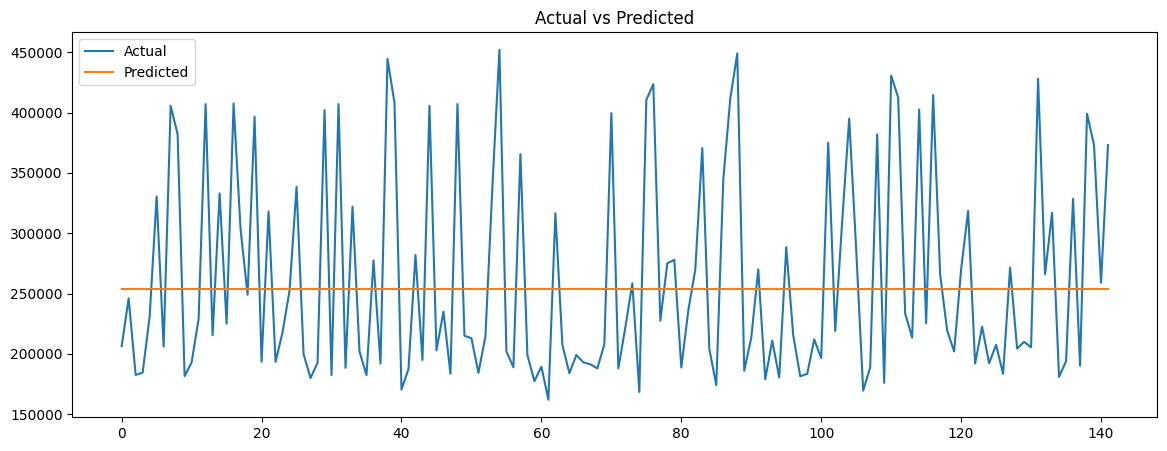

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training and Validation Loss')

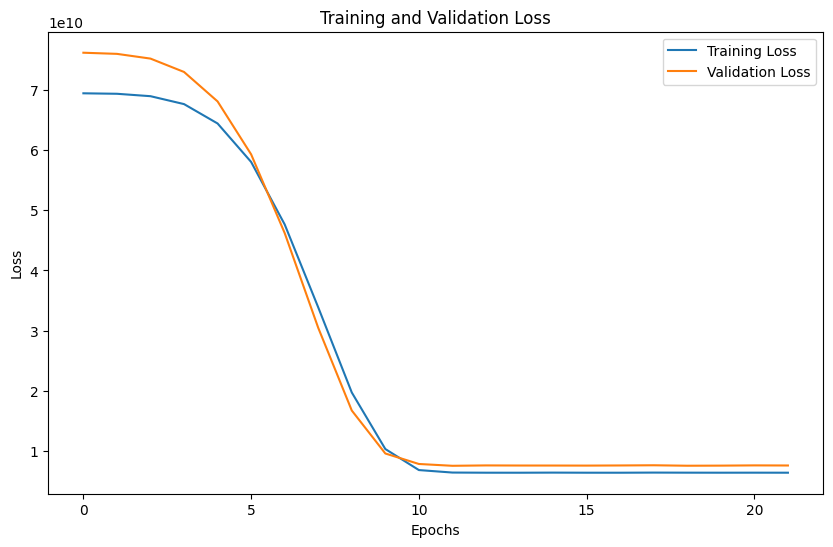

In [8]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras import regularizers

# 데이터 로드
data = pd.read_csv('/content/drive/MyDrive/미래에셋/final_naver.csv')
data.index = data["Date"]
data.drop("Date", axis = 1, inplace = True)
data

TARGET = "Close"
SEQ_SIZE = 30    # 10/30/60
PRED_SIZE = 1
LEARNING_RATE = 0.001
EPOCH = 30
BATCH_SIZE = 16  # 배치 크기 증가

def split_xy(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        tmp_x = dataset.iloc[i:x_end_number, :]
        tmp_y = dataset.iloc[x_end_number:y_end_number, :].loc[:, TARGET]
        x.append(tmp_x.values)
        y.append(tmp_y.values)

    return np.array(x), np.array(y)

X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
print(X[0],"\n", y[0])
print("X size : ", X.shape)
print("y size : ", y.shape)

# 시퀀스별로 Min-Max 정규화
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        min_val = np.min(X[i, :, j])
        max_val = np.max(X[i, :, j])
        if min_val == max_val:
            X[i, :, j] = 0
        else:
            X[i, :, j] = (X[i, :, j] - min_val) / (max_val - min_val)

# 결과 확인
print(X.shape)

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 초기화 함수
initializer = GlorotNormal()

# 모델 구성
model = Sequential([
    GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),  # 유닛 수 증가
    GRU(64),  # 유닛 수 증가
    Dense(128, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)),  # 유닛 수 증가
    Dense(64, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)),  # 유닛 수 증가
    Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001)),  # 유닛 수 증가
    Dense(1)
])
optimizer = Adam(learning_rate=LEARNING_RATE)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model.predict(X_test)

# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
